In [1]:
import datetime
import numpy as np
from influxdb import InfluxDBClient

In [2]:
client = InfluxDBClient(host='140.112.42.158', port=8086, database='test_2')

In [3]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'ko': 'Korean', 
        'ja': 'Japan',
        'es': 'Spanish',
        'fr': 'French',
        'ru': 'Russian',
        'west-us': 'West US',
        'US': 'United States',
        'SG': 'Singapore',
        'GB': 'Great Britain',
        'NL': 'Netherlands',
        'HK': 'Hong Kong'
    }

In [4]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def TIMEFMT(t):
    return datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ')

#### Calculate gorund truth

In [5]:
START_T = '2019-11-01T10:00:00Z' # start time
END_T = '2019-11-01T11:00:00Z'   # end time
q = build_query(START_T, END_T, loc='tw', lang='zh-tw')
result = client.query(q)

ground_truth, _ = get_edge_num(result) # total # of edge servers

In [6]:
START_T = '2019-11-01T10:00:00Z' # start time
END_T = '2019-11-01T11:00:00Z'   # end time
q = build_query(START_T, END_T, loc='tw', lang='zh-tw')
result = client.query(q)

M, _ = get_edge_num(result) # number of edge servers in first capture

In [7]:
START_T = '2019-11-01T20:00:00Z' # start time
END_T = '2019-11-01T21:00:00Z'   # end time
q = build_query(START_T, END_T, loc='tw', lang='zh-tw')
result = client.query(q)

C, _ = get_edge_num(result) # number of edge servers in second capture

#### Calculate intersection of edge servers between two captures 

In [8]:
R = M.intersection(C)
print(len(R))

13


#### Estimate total number of servers by CRC: $N=\dfrac{MC}{R}$

In [9]:
N = (len(M)*len(C))//len(R)
print(N)

33


#### Input whole week data 

In [10]:
def get_estimation(date, date_1, t1, t2, loc, lang):
    st = f'2019-11-{date}T00:00:00Z' 
    et = f'2019-11-{date_1}T00:00:00Z'
    m_st = f'2019-11-{date}T08:00:00Z'
    m_et = f'2019-11-{date}T{t1}Z'
    c_st = f'2019-11-{date}T16:00:00Z'
    c_et = f'2019-11-{date}T{t2}Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    gt, gt_t = get_edge_num(result) 
    
    q = build_query(m_st, m_et, loc=loc, lang=lang)
    result = client.query(q)
    M, M_t = get_edge_num(result) 
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    R = M.intersection(C)
    
    try:
        N = len(M)*len(C)/len(R)
    except ZeroDivisionError:
        N = 0
    
    return int(N), len(gt), gt_t, (M_t+C_t)

In [13]:
date =   ['01', '02', '03', '04', '05', '07', '08', '09', '10', '11']
date_1 = ['02', '03', '04', '05', '06', '08', '09', '10', '11', '12']
time_1 = ['08:15:00', '08:30:00', '09:00:00', '10:00:00', '12:00:00', '14:00:00', '16:00:00']
time_2 = ['16:15:00', '16:30:00', '17:00:00', '18:00:00', '20:00:00', '22:00:00', '23:59:59']

In [24]:
gt = [37, 37, 37, 38, 38, 70, 36, 36, 36, 38, 37]
est = [[], [], [], [], [], [], []]
trans = [[], [], [], [], [], [], []]
error = []

for i, (t1, t2) in enumerate(zip(time_1, time_2)):
    err = 0
    for d, d1 in zip(date, date_1):
        N, gt, gt_t, t = get_estimation(d, d1, t1, t2, 'tw', 'zh-tw')
        print(N, gt, t, gt_t)
        
        est[i].append(N)
        trans[i].append(t)
        
        err += (N-gt)**2
    err = (err/10)**(1/2)
    print(err)
    error.append(err)

30 37 716 18157
36 37 849 18081
33 37 641 15637
32 38 635 17637
42 38 595 18398
35 36 717 15602
27 36 641 10780
39 36 620 12891
31 38 598 12968
34 37 714 10940
5.167204273105526
30 37 1398 18157
36 37 1787 18081
35 37 1301 15637
34 38 1346 17637
39 38 1226 18398
33 36 1378 15602
29 36 1237 10780
38 36 1209 12891
30 38 1289 12968
35 37 1362 10940
4.483302354291979
31 37 2072 18157
36 37 2626 18081
35 37 1913 15637
34 38 2033 17637
38 38 1844 18398
34 36 2001 15602
30 36 1812 10780
38 36 1746 12891
30 38 1882 12968
36 37 1924 10940
4.0743097574926725
38 37 4007 18157
36 37 4879 18081
35 37 3805 15637
36 38 3655 17637
36 38 3529 18398
34 36 3907 15602
33 36 3441 10780
38 36 3477 12891
31 38 3776 12968
36 37 3786 10940
2.8460498941515415
37 37 6935 18157
36 37 7922 18081
37 37 6504 15637
36 38 6776 17637
37 38 6242 18398
33 36 6014 15602
33 36 4851 10780
36 36 5352 12891
33 38 5943 12968
35 37 4795 10940
2.3021728866442674
37 37 10720 18157
36 37 10371 18081
37 37 8807 15637
37 38 10015 17

In [16]:
# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

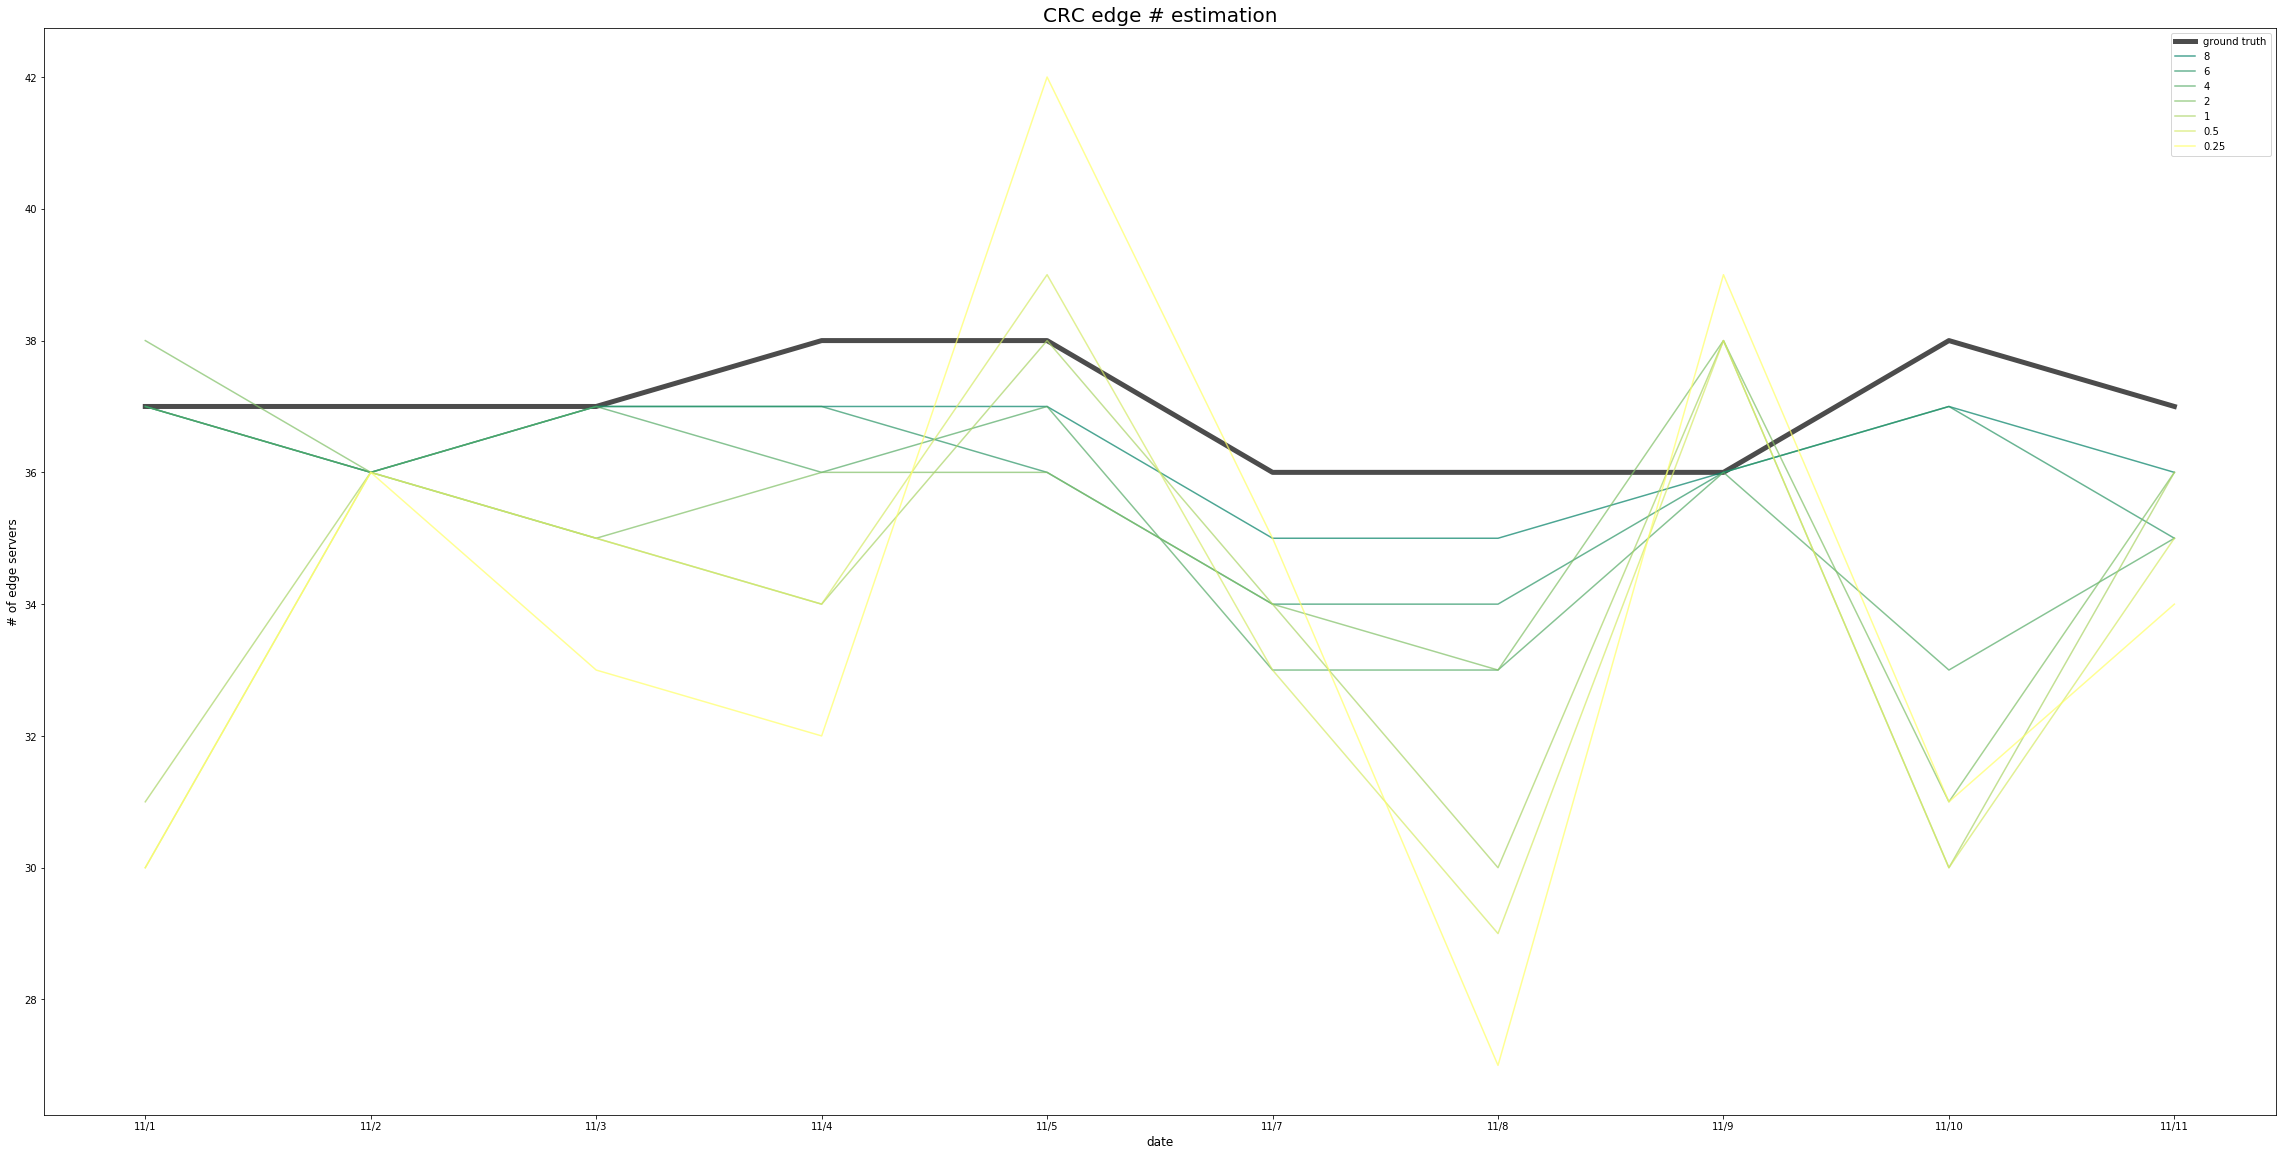

In [21]:
gt = [37, 37, 37, 38, 38, 36, 36, 36, 38, 37]
fig, ax = plt.subplots(figsize=(40, 20))
# x_axis = list(range(len(gt)))
x_axis = ['11/1','11/2', '11/3', '11/4', '11/5', '11/7', '11/8', '11/9', '11/10', '11/11']
labels = ['8', '6', '4', '2', '1', '0.5', '0.25']
ax.set_xlabel('date', fontsize=12)
ax.set_ylabel('# of edge servers', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, gt, linewidth=5, color='black', label='ground truth', alpha=0.7)
for i, (c, e) in enumerate(zip(color_idx, est[::-1])):
    plt.plot(x_axis, e, color=plt.cm.summer(c), label=labels[i], alpha=0.7)
    
plt.title('CRC edge # estimation', fontsize=20)
plt.legend()
plt.show()


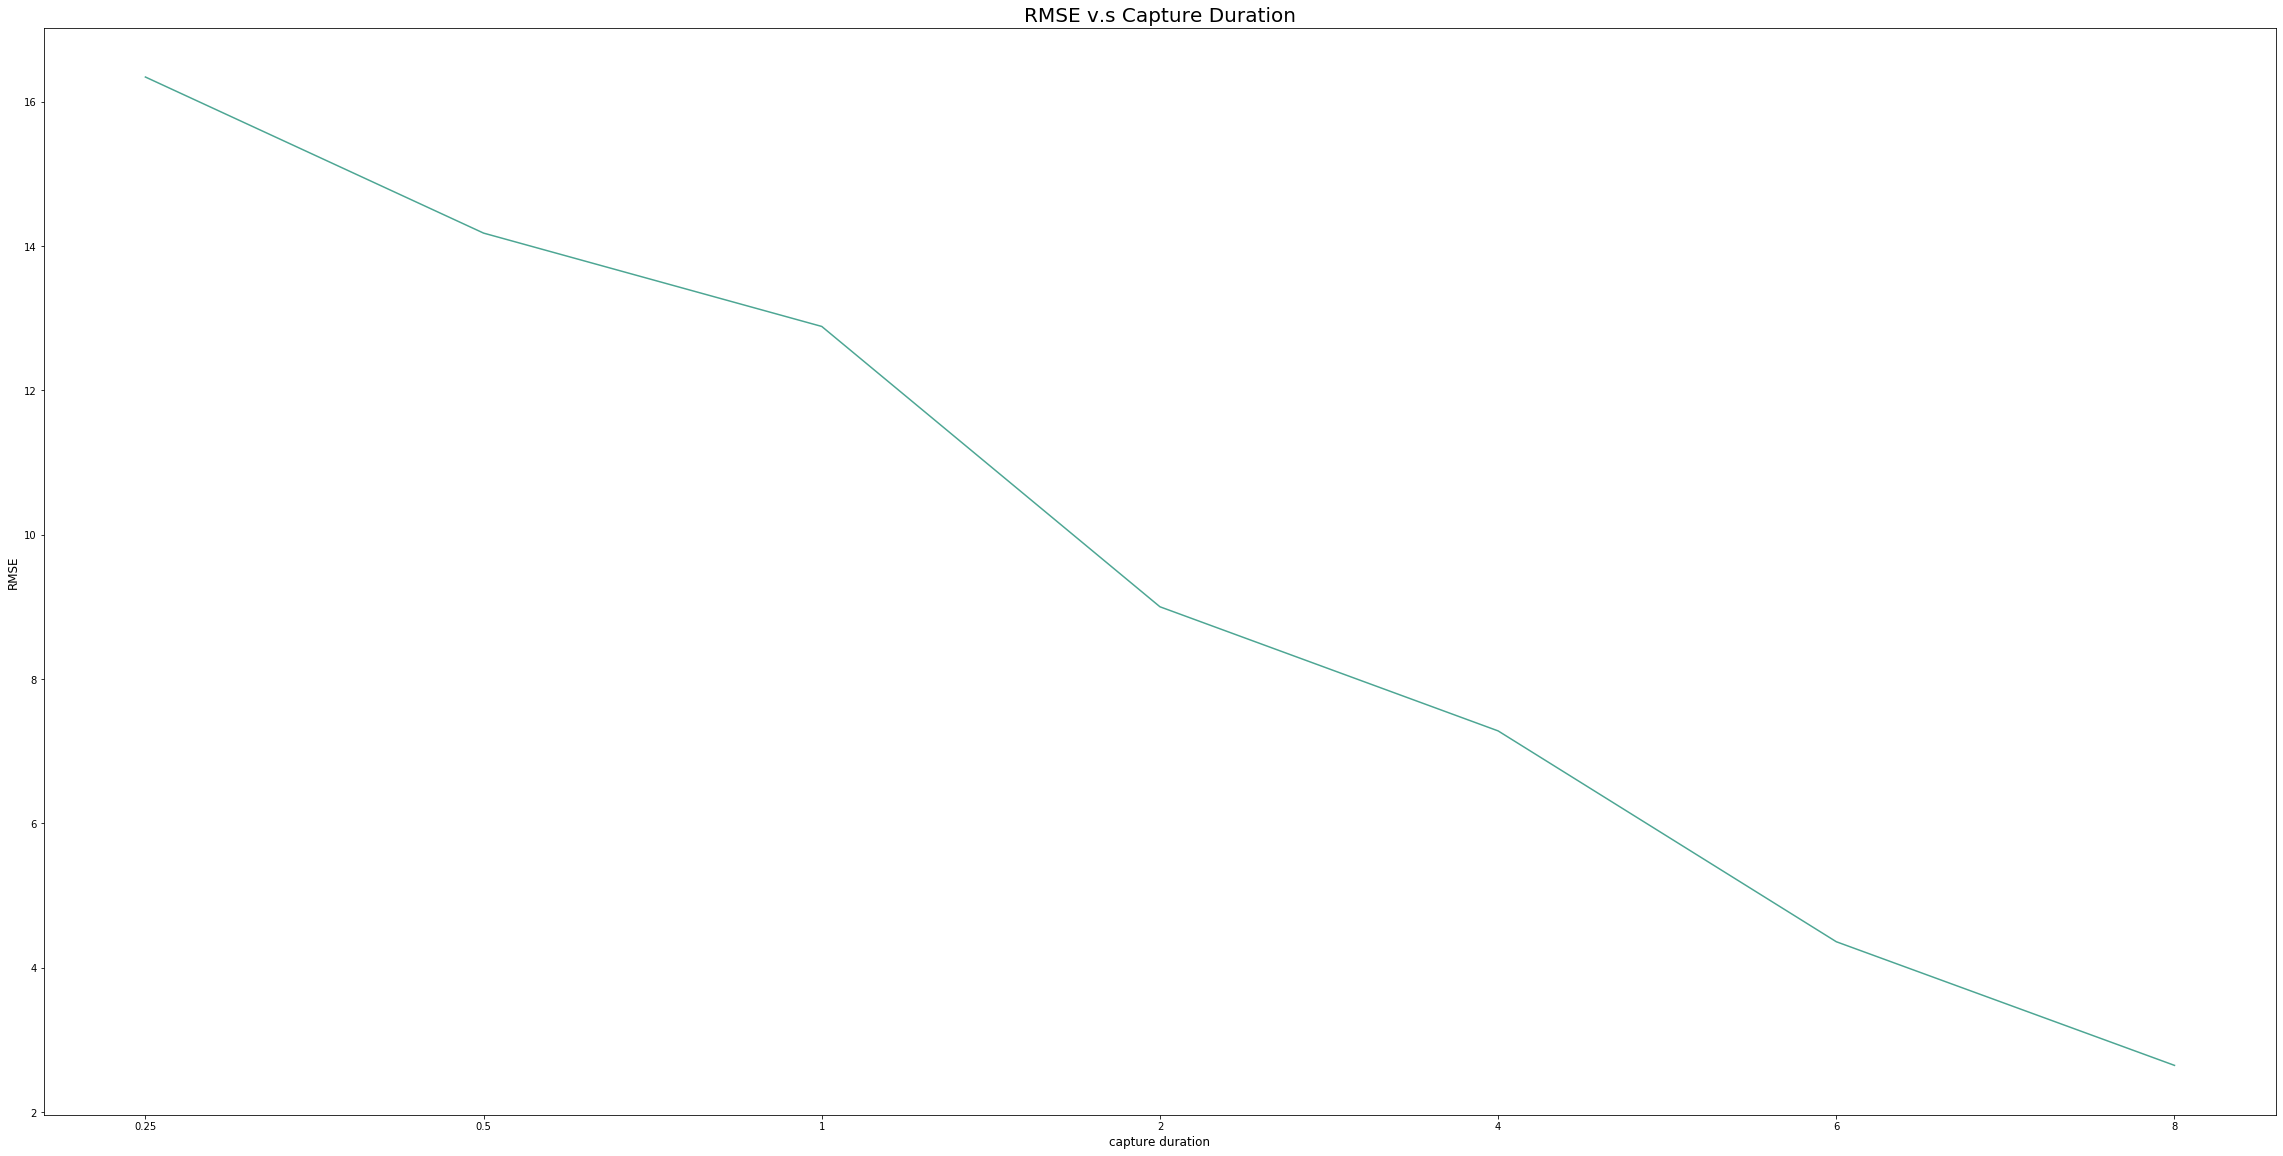

In [22]:
gt = [37, 37, 37, 38, 38, 36, 36, 36, 38, 37]
fig, ax = plt.subplots(figsize=(40, 20))
x_axis = ['0.25', '0.5', '1', '2', '4', '6', '8']

ax.set_xlabel('capture duration', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, error, color=plt.cm.summer(1), alpha=0.7)
plt.title('RMSE v.s Capture Duration', fontsize=20)

plt.show()

#### TODO: Plot # of reduction in transactions

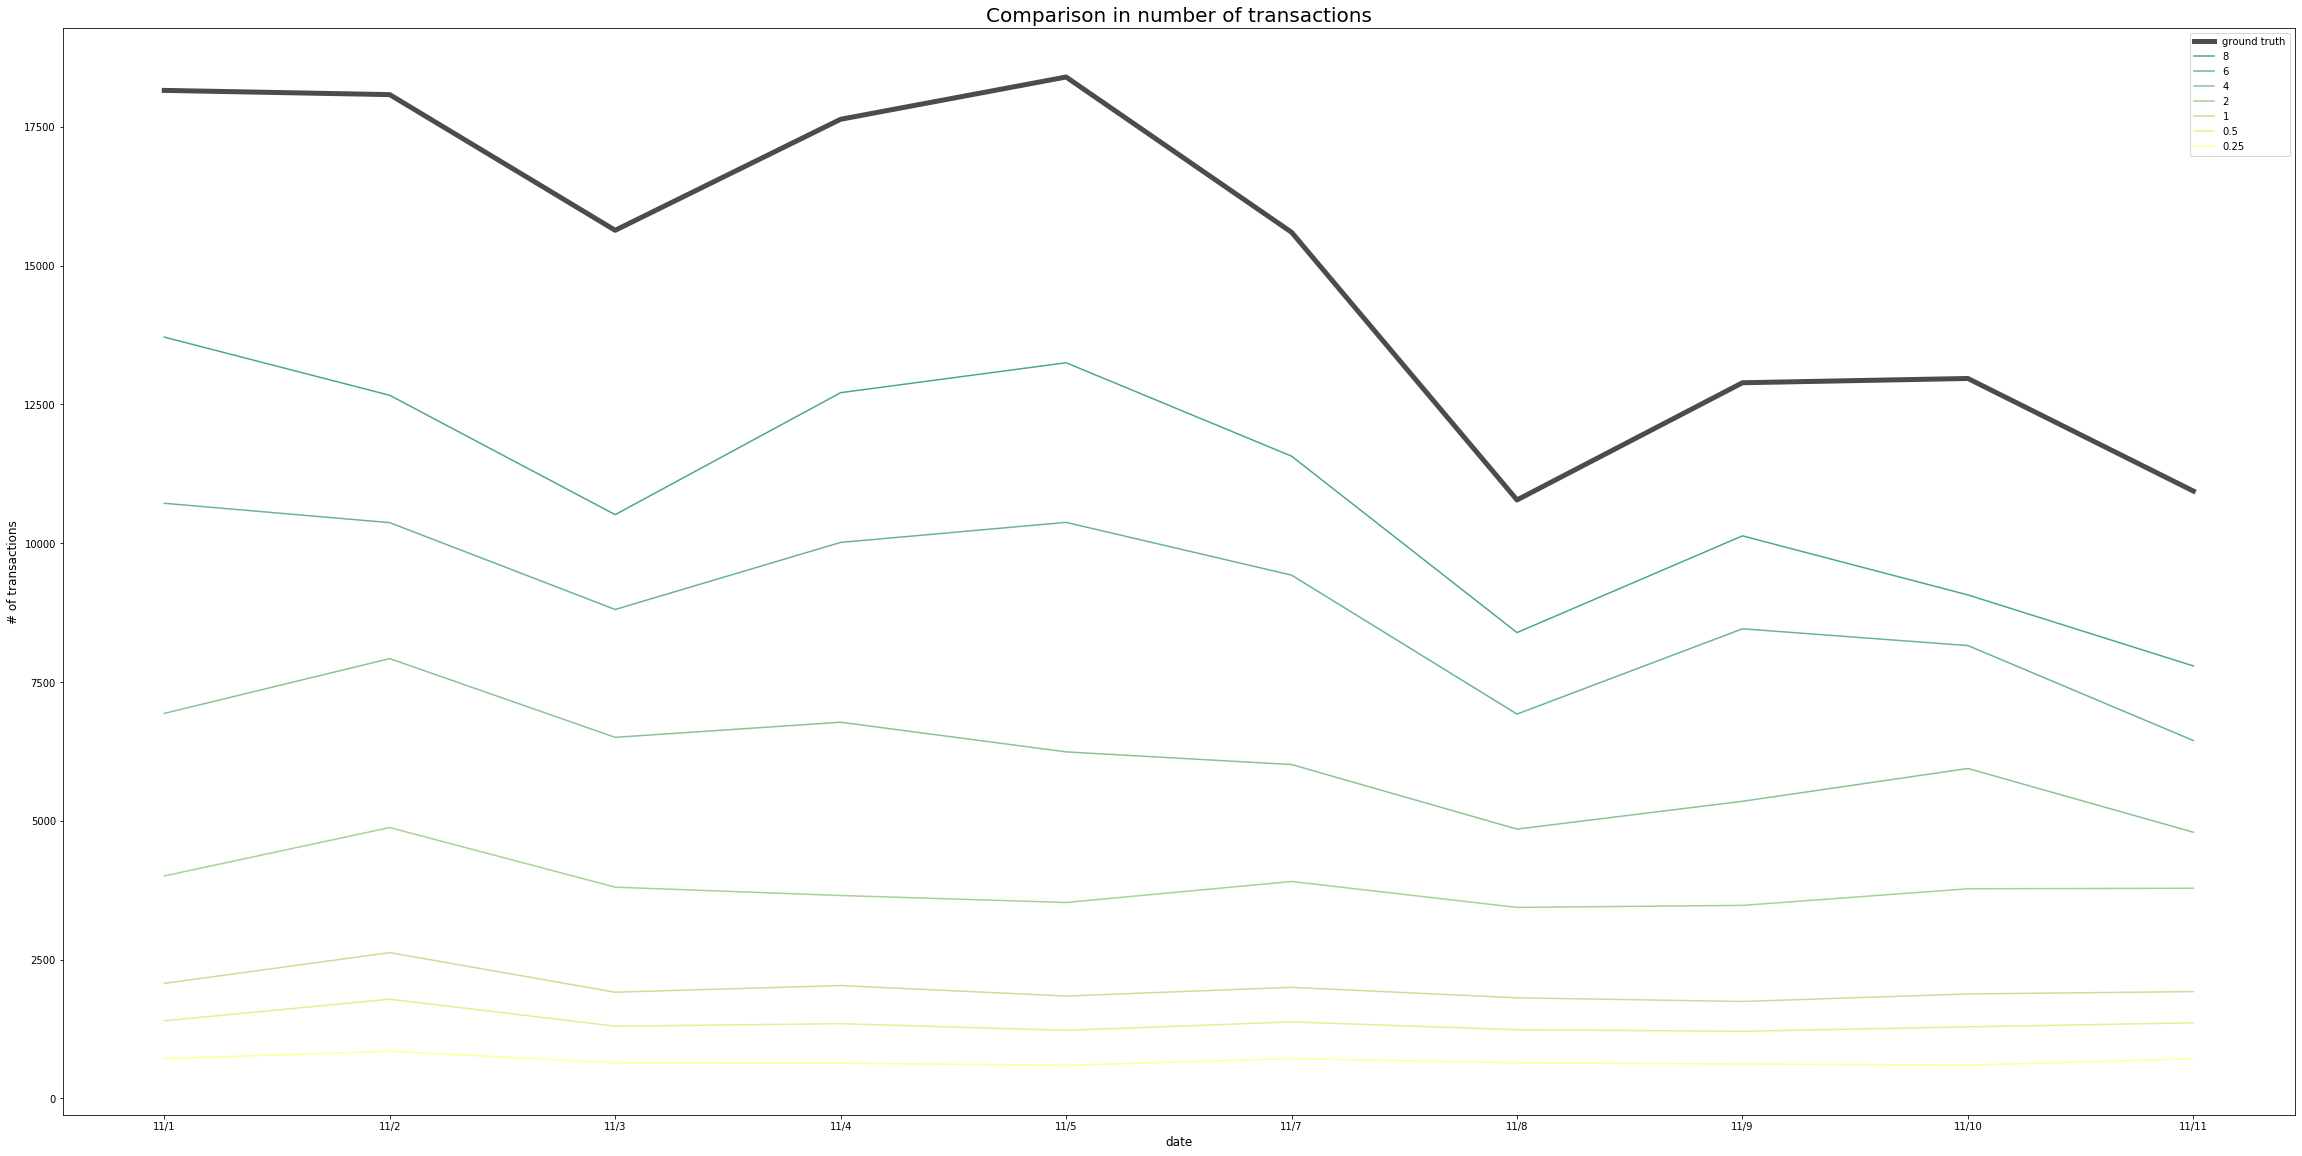

In [23]:
gt = [18157, 18081, 15637, 17637, 18398, 15602, 10780, 12891, 12968, 10940]
fig, ax = plt.subplots(figsize=(40, 20))
x_axis = ['11/1','11/2', '11/3', '11/4', '11/5', '11/7', '11/8', '11/9', '11/10', '11/11']
labels = ['8', '6', '4', '2', '1', '0.5', '0.25']
ax.set_xlabel('date', fontsize=12)
ax.set_ylabel('# of transactions', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, gt, linewidth=5, color='black', label='ground truth', alpha=0.7)
for i, (c, e) in enumerate(zip(color_idx, trans[::-1])):
    plt.plot(x_axis, e, color=plt.cm.summer(c), label=labels[i], alpha=0.7)
    
plt.title('Comparison in number of transactions', fontsize=20)
plt.legend()
plt.show()